<a href="https://colab.research.google.com/github/MojTabaa4/MNIST-classifier/blob/main/fashion_MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Load the Fashion-MNIST dataset into memory
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [2]:

import numpy as np
import matplotlib.pyplot as plt

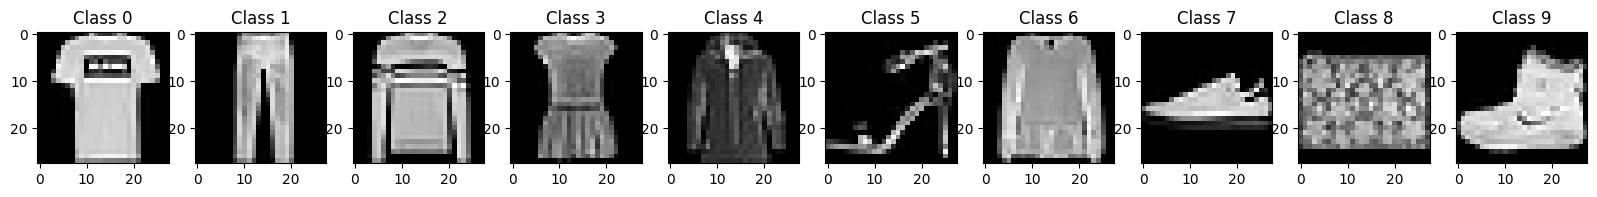

In [3]:
unique_classes = np.unique(train_labels)

# Create a grid of subplots
fig, axs = plt.subplots(1, len(unique_classes), figsize=(20, 5))

# Plot one image from each class in a separate subplot
for i, cls in enumerate(unique_classes):
    idx = np.where(train_labels == cls)[0][0]
    axs[i].imshow(train_images[idx], cmap='gray')
    axs[i].set_title(f"Class {cls}")

plt.show()

Text(0.5, 1.0, 'Class Frequency in Train Labels')

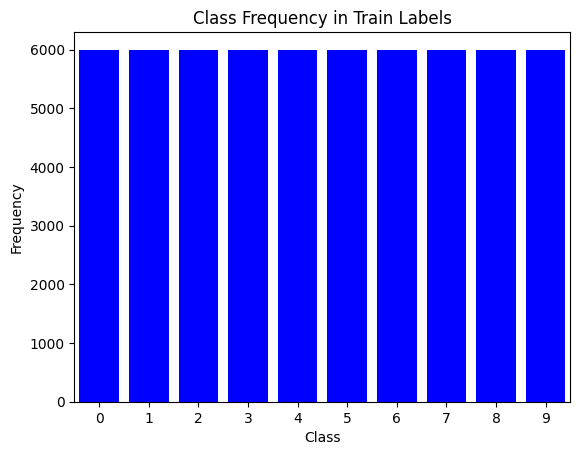

In [4]:
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

plt.bar(unique_classes, class_counts, color='b')
plt.xticks(unique_classes)  # set the x-ticks to the unique classes

# set the x-axis limits to show all unique classes
plt.xlim(unique_classes[0] - 0.5, unique_classes[-1] + 0.5)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency in Train Labels')

Text(0.5, 1.0, 'Class Frequency in Test Labels')

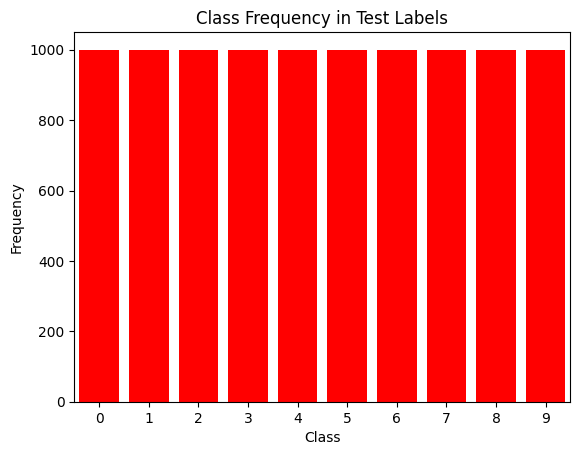

In [5]:
unique_classes, class_counts = np.unique(test_labels, return_counts=True)

plt.bar(unique_classes, class_counts, color='r')
plt.xticks(unique_classes)

plt.xlim(unique_classes[0] - 0.5, unique_classes[-1] + 0.5)

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency in Test Labels')

In [10]:
from typing import Tuple, Optional

class DataLoader:
    def __init__(self, data: np.ndarray, labels: np.ndarray, batch_size: Optional[int] = 32, shuffle: Optional[bool] = True) -> None:
        # Initialize the data and labels arrays, batch size, and shuffle flag
        self.__data = data
        self.__labels = labels
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        
        # Compute the number of samples and classes in the dataset
        self.__num_samples = data.shape[0]
        self.__num_classes = np.max(labels) + 1
        
        # One-hot encode the labels using np.eye()
        self.__onehot_labels = np.eye(self.__num_classes)[labels]
        
    def __shuffle_dataset(self) -> None:
        # Shuffle the data and one-hot encoded labels using np.random.permutation()
        indices = np.random.permutation(self.__num_samples)
        self.__data = self.__data[indices]
        self.__onehot_labels = self.__onehot_labels[indices]
        
    def __iter__(self) -> Tuple[np.matrix, np.matrix]:
        if self.__shuffle:
            self.__shuffle_dataset()
            
        # If batch size is None, yield the entire dataset as a single batch
        if self.__batch_size == None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        # Iterateover the data in batches of size batch_size
        for idx in range(0, len(self.__data), self.__batch_size):
            # Extract the corresponding batch of data and one-hot encoded labels
            batch_data = np.matrix(self.__data[idx:idx+self.__batch_size])
            batch_labels = np.matrix(self.__onehot_labels[idx:idx+self.__batch_size])
            
            # Yield the batch as a tuple
            yield (batch_data, batch_labels)

# Activation Fuctions

In [20]:
class ActivationFunction:
    def __init__(self):
        pass
    
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    
    def __call__(self, matrix: np.ndarray) -> np.ndarray:
        return self.__compute_value(matrix)
 

In [21]:
class Identical(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        return np.matrix(matrix, dtype=np.float32)
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        return np.matrix(np.full(np.shape(matrix), 1.), dtype=np.float32)


In [22]:
class Relu(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        relu_value = np.maximum(matrix, 0)
        return np.matrix(relu_value, dtype=np.float32)
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        relu_derivative = np.where(matrix > 0, 1.0, 0.0)
        return np.matrix(relu_derivative, dtype=np.float32)

In [24]:
class LeakyRelu(ActivationFunction):
    def __init__(self, negative_slope: float = 0.01) -> None:
        self.negative_slope = negative_slope
    
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_value = np.maximum(matrix, 0)
        negative_part = np.minimum(matrix, 0) * self.negative_slope
        return np.matrix(leaky_relu_value + negative_part, dtype=np.float32)
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        leaky_relu_derivative = np.where(matrix > 0, 1.0, self.negative_slope)
        return np.matrix(leaky_relu_derivative, dtype=np.float32)

In [25]:
class Sigmoid(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = 1 / (1 + np.exp(-matrix))
        return np.matrix(sigmoid_value, dtype=np.float32)
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        sigmoid_value = self.__compute_value(matrix)
        sigmoid_derivative = np.multiply(sigmoid_value, 1 - sigmoid_value)
        return np.matrix(sigmoid_derivative, dtype=np.float32)

In [26]:
class Softmax(ActivationFunction):
    def __compute_value(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        softmax_value /= np.sum(softmax_value, axis=1, keepdims=True)
        return softmax_value
    
    def derivative(self, matrix: np.ndarray) -> np.ndarray:
        softmax_value = self.__compute_value(matrix)
        return softmax_value * (1 - softmax_value)

# Loss function

In [12]:
class CrossEntropy:
    def __init__(self):
        self.softmax = Softmax()

    def __compute_value(self, true_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert true_val.shape == expected_val.shape
        expected_val_softmax = self.softmax(expected_val)
        loss = -np.sum(true_val * np.log(expected_val_softmax), axis=1, keepdims=True)
        return loss
    
    def derivative(self, true_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        assert true_val.shape == expected_val.shape
        expected_val_softmax = self.softmax(expected_val)
        return expected_val_softmax - true_val
    
    def __call__(self, true_val: np.ndarray, expected_val: np.ndarray) -> np.ndarray:
        return self.__compute_value(true_val, expected_val)


# Neural Layer Class

In [13]:
import numpy as np
import math
from typing import Optional

class NeuralLayer:
    # Default values for initialization parameters
    DEFAULT_LOW: float = 0
    DEFAULT_HIGH: float = 0.05
    DEFAULT_MEAN: float = 0.
    DEFAULT_VAR: float = 1.

    def __init__(self, input_size: int, output_size: int, activation, initial_weight: str = 'uniform', **initializing_parameters):
        """
        Initializes a layer of neurons with the specified input and output sizes,
        activation function, and weight initialization method.

        Args:
            input_size (int): The number of input neurons.
            output_size (int): The number of output neurons.
            activation (Activation): The activation function to use for the layer.
            initial_weight (str): The weight initialization method to use.
            **initializing_parameters: Additional parameters for weight initialization.

        Raises:
            ValueError: If the activation function is not specified.
            ValueError: If the weight initialization method is not recognized.
        """
        if activation is None:
            raise ValueError('Activation function must be specified!')
        
        # Dictionary to map weight initialization method names to functions
        weight_initializer_methods = {
            'uniform': self.__uniform_weight, 
            'normal': self.__normal_weight
        }

        if initial_weight not in weight_initializer_methods:
            raise ValueError('Undefined weight initialization function!')
        
        # Initialize instance variables
        self.n_neurons: int = output_size
        self.weight_initializer = weight_initializer_methods[initial_weight]
        self.weight = self.weight_initializer(input_size, self.n_neurons, **initializing_parameters)
        self.bias = self.weight_initializer(1, self.n_neurons, **initializing_parameters)
        self.activation = activation
        
        # Last computed values
        self.last_input: Optional[np.ndarray] = None
        self.last_activation_input: Optional[np.ndarray] = None
        self.last_activation_output: Optional[np.ndarray] = None
        self.last_activation_derivative: Optional[np.ndarray] = None
        
    def forward(self, layer_input: np.ndarray) -> np.ndarray:
        """
        Computes the output of the layer given an input.

        Args:
            layer_input (ndarray): The input to the layer.

        Returns:
            ndarray: The output of the layer.

        Raises:
            ValueError: If the input is not a 2D array.
            ValueError: If the input size does not match the weight size.
        """
        if np.ndim(layer_input) != 2:
            raise ValueError('Input must be a 2D array!')
        if np.size(self.weight, 0) != np.size(layer_input, 1):
            raise ValueError(f'Weight shape 0 {np.size(self.weight, 0)} and Layer shape 1 {np.size(layer_input, 1)} do not match!')
        
        # Compute activation input, output, and derivative
        self.last_input = layer_input
        self.last_activation_input = np.matmul(layer_input, self.weight) + self.bias
        self.last_activation_output = self.activation(self.last_activation_input)
        self.last_activation_derivative = self.activation.derivative(self.last_activation_input)

        return self.last_activation_output
    
    def update_weights(self, backprop_tensor: np.ndarray, lr: float) -> np.ndarray:
        """
        Updates the weights of the layer given a backpropagation tensor and a learning rate.

        Args:
            backprop_tensor (ndarray): The backpropagation tensor from the next layer.
            lr (float): The learning rate.

        Returns:
            ndarray: The backpropagation tensor for the current layer.

        Raises:
            ValueError: If the backprop tensor is not a 2D array.
            ValueError: If the backprop tensor shape does not match the activation derivative shape.
            ValueError: If the backprop tensor shape does not match the number of neurons in the layer.
        """
        if np.ndim(backprop_tensor) != 2:
            raise ValueError('Backprop tensor must be a 2D array!')
        if np.size(backprop_tensor, 0) != np.size(self.last_activation_derivative, 0):
            raise ValueError(f'Backprop tensor shape 0 {np.size(backprop_tensor, 1)} and activation derivative shape 0 {np.size(self.last_activation_derivative, 0)} do not match!')
        if np.size(backprop_tensor, 1) != self.n_neurons:
            raise ValueError(f'Backprop tensor shape 1 {np.size(backprop_tensor, 1)} and number of neurons {self.n_neurons} do not match!')
        
        # Compute gradients and update weights and biases
        bias_mul = np.ones(np.size(backprop_tensor, 0))
        bias_mul = np.asmatrix(bias_mul)
        derivation_of_L_to_Y = np.multiply(self.last_activation_derivative, backprop_tensor)
        derivation_of_L_to_W = np.matmul(self.last_input.T, derivation_of_L_to_Y)
        derivation_of_L_to_B = np.matmul(bias_mul, derivation_of_L_to_Y)
        backprop_tensor = np.matmul(derivation_of_L_to_Y, self.weight.T)
        self.weight = self.weight - lr * derivation_of_L_to_W
        self.bias = self.bias - lr * derivation_of_L_to_B

        return backprop_tensor

    def __uniform_weight(self, dim1: int, dim2: int, **initializing_parameters) -> np.ndarray:
        """
        Initializes weights using a uniform distribution with the specified parameters.

        Args:
            dim1 (int): The first dimension of the weight matrix.
            dim2 (int): The second dimension of the weight matrix.

        Returns:
            ndarray: The initialized weight matrix.
        """
        low = initializing_parameters.get('low', self.DEFAULT_LOW)
        high = initializing_parameters.get('high', self.DEFAULT_HIGH)
        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))
        weights = np.asmatrix(weights)

        return weights

    def __normal_weight(self, dim1: int, dim2: int, **initializing_parameters) -> np.ndarray:
        """
        Initializes weights using a normal distribution with the specified parameters.

        Args:
            dim1 (int): The first dimension of the weight matrix.
            dim2 (int): The second dimension of the weight matrix.

        Returns:
            ndarray: The initialized weight matrix.
        """
        mean = initializing_parameters.get('mean', self.DEFAULT_MEAN)
        var = initializing_parameters.get('var', self.DEFAULT_VAR)
        weights = np.random.normal(loc=mean, scale=math.sqrt(var), size=(dim1, dim2))
        weights = np.asmatrix(weights)

        return weights

# Feed Forward Class

In [16]:
from typing import List, Tuple, Dict, Optional, Iterable


class FeedForwardNN:
    """
    A feedforward neural network class with customizable layers,
    loss function, and optimization algorithm for training.

    Example usage:

    model = FeedForwardNN(input_shape=200)
    model.add_layer(256, activation=Relu())
    model.add_layer(10, activation=Softmax())
    model.set_training_param(loss=CrossEntropy(), lr=1e-3)
    log = model.fit(epochs=10, trainloader=trainloader, testloader=testloader)
    """

    def __init__(self, input_shape: int):
        """
        Initialize a new feedforward neural network object.

        Args:
            input_shape: int, the shape of the input data (number of features).
        """
        self._input_shape = input_shape
        self._output_shape = None
        self._layers_list = []
        self._lr = None
        self._loss = None

    def add_layer(self,
                  n_neurons: int,
                  activation,
                  initial_weight: str = 'uniform',
                  **initializing_parameters) -> None:
        """
        Add a new layer to the neural network.

        Args:
            n_neurons: int, the number of neurons in the new layer.
            activation: an instance of an activation function class.
            initial_weight: str, the initialization method for the layer weights            (default is 'uniform').
            **initializing_parameters: additional parameters for the weight initialization method.

        Returns:
            None.
        """
        self._validate_neurons_number(n_neurons)

        n_prev_neurons = self._input_shape if not self._layers_list else self._layers_list[-1].n_neurons
        new_layer = NeuralLayer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self._layers_list.append(new_layer)
        self._output_shape = self._layers_list[-1].n_neurons 

    def set_training_param(self, loss, lr: float) -> None:
        """
        Set the loss function and learning rate for the neural network training.

        Args:
            loss: an instance of a loss function class.
            lr: float, the learning rate for the optimization algorithm.
        """
        if not self._layers_list:
            raise ValueError("Incomplete model")

        self._loss = loss
        self._lr = lr

    def forward(self, network_input: np.ndarray) -> np.ndarray:
        """
        Perform a forward pass through the neural network.

        Args:
            network_input: numpy array, the input data to the neural network.

        Returns:
            numpy array, the output of the neural network.
        """
        if not self._output_shape:
            raise ValueError("Model is not compiled!")

        for layer in self._layers_list:
            network_input = layer.forward(network_input)

        network_output = network_input

        return network_output

    def fit(self, 
            epochs: int,
            trainloader: Iterable[Tuple[np.ndarray, np.ndarray]],
            testloader: Optional[Iterable[Tuple[np.ndarray, np.ndarray]]] = None,
            print_results: bool = True) -> Dict[str, List[float]]:
        """
        Train the neural network on a given dataset for a specified number of epochs.

        Args:
            epochs: int, the number of training epochs.
            trainloader: an iterable that provides batches of training data.
            testloader: an iterable that provides batches of test data (optional).
            print_results: bool, whether to print the results after each epoch.

        Returns:
            dict, a log of the training and test accuracy and loss for each epoch.
        """
        self._validate_model_and_params()
        log = {"train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}
        
        for epoch in range(1, epochs+1):
            if print_results: 
                print(f'Epoch {epoch}:')

            train_accuracy, train_loss = self._train(trainloader)

            log['train_accuracy'].append(train_accuracy)
            log['train_loss'].append(train_loss)

            if print_results:
                print(f'\tTrain: Average Accuracy: {train_accuracy}\tAverage Loss: {train_loss}')

            if testloader:
                test_accuracy, test_loss = self._test(testloader)
                log['test_accuracy'].append(test_accuracy)
                log['test_loss'].append(test_loss)
                if print_results:
                    print(f'\tTest: Average Accuracy: {test_accuracy}\tAverage Loss:{test_loss}')

        return log

    def _train(self, trainloader: Iterable[Tuple[np.ndarray, np.ndarray]]) -> Tuple[float, float]:
        """
        Train the neural network on a single batch of training data.

        Args:
            trainloader: an iterable that provides batches of training data.

        Returns:
            float, the average training accuracy on the batch.
            float, the average training loss on the batch.
        """
        return self._run_on_loader(trainloader, train=True)

    def _test(self, testloader: Iterable[Tuple[np.ndarray, np.ndarray]]) -> Tuple[float, float]:
        """
        Test the neural network on a single batch of test data.

        Args:
            testloader: an iterable that provides batches of test data.

        Returns:
            float, the average test accuracy on the batch.
            float, the average test loss on the batch.
        """
        return self._run_on_loader(testloader, train=False)

    def _run_on_loader(self, loader: Iterable[Tuple[np.ndarray, np.ndarray]], train: bool) -> Tuple[float, float]:
        """
        Run the neural network on a given dataset (train or test).

        Args:
            loader: an iterable that provides batches of data.
            train: bool, whether to train the network or not.

        Returns:
            float, the average accuracy on the dataset.
            float, the average loss on the dataset.
        """
        accuracies, losses = [], []

        for x_batch, y_batch in loader:
            accuracy, loss = self._run_on_batch(x_batch, y_batch, train)
            accuracies.append(accuracy)
            losses.append(loss)

        return np.mean(accuracies), np.mean(losses)

    def _run_on_batch(self, x_batch: np.ndarray, y_batch: np.ndarray, train: bool) -> Tuple[float, float]:
        """
        Run the neural network on a single batch of data.

        Args:
            x_batch: numpy array, the input data for the batch.
            y_batch: numpy array, the target output data for the batch.
            train: bool, whether to train the network or not.

        Returns:
            float, the accuracy on the batch.
            float, the average loss on the batch.
        """
        batch_res = self.forward(x_batch)
        batch_accuracy = self._compute_accuracy(batch_res, y_batch)
        batch_losses = self._loss(y_batch, batch_res)
        batch_average_loss = np.mean(batch_losses)

        if train:
            self._update_weights(batch_res, y_batch)

        return batch_accuracy, batch_average_loss

    def _get_labels(self, outputs: np.ndarray) -> np.ndarray:
        """
        Convert the predicted output probabilities into binary labels.

        Args:
            outputs: numpy array, the predicted output probabilities.

        Returns:
            numpy array, the binary labels.
        """
        labels = np.zeros_like(outputs)
        labels[np.arange(len(outputs)), outputs.argmax(1)] = 1
        return labels

    def _compute_accuracy(self, output: np.ndarray, expected_output: np.ndarray) -> float:
        """
        Compute the accuracy of the predicted output with respect to the expected output.

        Args:
            output: numpy array, the predicted output from the neural network.
            expected_output: numpy array, the ground truth output.

        Returns:
            float, the accuracy of the predicted output.
        """
        output_labels = self._get_labels(output)
        expected_labels = self._get_labels(expected_output)
        accuracy = np.mean(np.all(output_labels == expected_labels, axis=1))
        return accuracy

    def _update_weights(self, output: np.ndarray, y_train: np.ndarray) -> None:
        """
        Update the weights of the neural network based on the predicted output and the ground truth output.

        Args:
            output: numpy array, the predicted output from the neural network.
            y_train: numpy array, the ground truth output.
            
        """
        derivation_of_layer = self._loss.derivative(y_train, output)

        for layer in reversed(self._layers_list):
            derivation_of_layer = layer.update_weights(derivation_of_layer, self._lr)

    def _validate_neurons_number(self, n_neurons):
        """
        Check that the number of neurons is a positive integer.

        Args:
            n_neurons: int, the number of neurons.

        Raises:
            ValueError: if the number of neurons is not a positive integer.
        """
        if not isinstance(n_neurons, int) or n_neurons <= 0:
            raise ValueError("Invalid number of neurons for the layer!")

    def _validate_model_and_params(self):
        """
        Check that the neural network is fully defined and the training parameters are set        properly.

        Raises:
            ValueError: if the neural network is not fully defined or the training parameters are not set.
        """
        if not self._output_shape:
            raise ValueError("Model is not compiled!")
        if not self._lr or not self._loss:
            raise ValueError("Training parameters are not set!")